# Stehsatz(!)
### Grundstückspreise (Median) der im Freihandkauf umgesetzten bebauten Grundstücke nach Stadtquartier und Zonenart (ohne StWE, nur BZO99), bis 2018
Diese Daten beihnalten die die Medianpreise pro Quadratmeter Bauland von gehandelten Grundstücken in der Stadt Zürich nach Handänderungsjahr, Stadtquartier und Zonenart. Aufgrund der Einführung der neuen Bau- und Zonenordnung im November 2018 endet die Zeitreihe im November 2018.

**Anpassung vom 07.11.2022: OD5125 wurde zu OD5173. Ab dem 3.2.2023 wird sich auch die Datenstruktur ändern.**

Datum: 07.02.2022

### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [3]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [4]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [5]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 11 datenstand:  9 time.struct_time(tm_year=2022, tm_mon=11, tm_mday=11, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=315, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [6]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_hae_preis_quartier_zonenart_ohne_stwe_bzo99_bis2018_od5173

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_hae_preis_quartier_zonenart_ohne_stwe_bzo99_bis2018_od5173


In [7]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [8]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_hae_preis_quartier_zonenart_ohne_stwe_bzo99_bis2018_od5173/download/BAU517OD5173.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_hae_preis_quartier_zonenart_ohne_stwe_bzo99_bis2018_od5173\BAU517OD5173.csv"   

print(fp)

https://data.stadt-zuerich.ch/dataset/bau_hae_preis_quartier_zonenart_ohne_stwe_bzo99_bis2018_od5173/download/BAU517OD5173.csv


In [9]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['Stichtagdatjahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In [10]:
#Abfangen immer anderer Schreibweisen der Zeitvariabeln
data2betested["Jahr"] =data2betested[["Stichtagdatjahr"]]
data2betested["StichtagDatJahr"] =data2betested[["Stichtagdatjahr"]]
data2betested.head(1)

,Stichtagdatjahr,QuarLang,QuarCd,QuarSort,qmp_verk_grstfl,ZonenSSZPubl1Cd,ZonenSSZPubl1Lang,...,BetrachteteHALang,BetrachteteHASort,BZOCd,BZOLang,BZOSort,Jahr,StichtagDatJahr
0,2014-01-01,Affoltern,111,111,4070,130,Kernzone,...,Freihandkäufe ohne Stockwerkeigentum,2,0,BZO99,0,2014-01-01,2014-01-01


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [11]:
#data2betested.head(6)

In [12]:
data2betested.dtypes

Stichtagdatjahr      datetime64[ns]
QuarLang                     object
QuarCd                        int64
QuarSort                      int64
qmp_verk_grstfl               int64
ZonenSSZPubl1Cd               int64
ZonenSSZPubl1Lang            object
ZonenSSZPubl1Sort             int64
Anzahl_HAE                   object
HAArtLevel2Lang              object
HAArtLevel2Sort               int64
HAArtLevel2Cd                 int64
DatenstandCd                 object
HandaenderungCd               int64
HandaenderungLang            object
HandaenderungSort             int64
AbzugGVZCd                    int64
AbzugGVZSort                  int64
AbzugGVZLang                 object
BetrachteteHACd               int64
BetrachteteHALang            object
BetrachteteHASort             int64
BZOCd                         int64
BZOLang                      object
BZOSort                       int64
Jahr                 datetime64[ns]
StichtagDatJahr      datetime64[ns]
dtype: object

In [13]:
data2betested.shape

(874, 27)

Beschreibe einzelne Attribute

In [14]:
data2betested.describe()

,QuarCd,QuarSort,qmp_verk_grstfl,ZonenSSZPubl1Cd,ZonenSSZPubl1Sort,HAArtLevel2Sort,HAArtLevel2Cd,HandaenderungCd,HandaenderungSort,AbzugGVZCd,AbzugGVZSort,BetrachteteHACd,BetrachteteHASort,BZOCd,BZOSort
count,874,874,874,874,874,874,874,874,874,874,874,874,874,874,874
mean,72,72,10879,117,118,1,1,1,1,0,0,2,2,0,0
std,35,35,14701,12,12,0,0,0,0,0,0,0,0,0,0
min,11,11,0,110,111,1,1,1,1,0,0,2,2,0,0
25%,34,34,3915,111,112,1,1,1,1,0,0,2,2,0,0
50%,73,73,6380,112,113,1,1,1,1,0,0,2,2,0,0
75%,102,102,12430,113,120,1,1,1,1,0,0,2,2,0,0
max,123,123,191430,161,161,1,1,1,1,0,0,2,2,0,0


Wie viele Nullwerte gibt es im Datensatz?

In [15]:
data2betested.isnull().sum()

Stichtagdatjahr      0
QuarLang             0
QuarCd               0
QuarSort             0
qmp_verk_grstfl      0
ZonenSSZPubl1Cd      0
ZonenSSZPubl1Lang    0
ZonenSSZPubl1Sort    0
Anzahl_HAE           0
HAArtLevel2Lang      0
HAArtLevel2Sort      0
HAArtLevel2Cd        0
DatenstandCd         0
HandaenderungCd      0
HandaenderungLang    0
HandaenderungSort    0
AbzugGVZCd           0
AbzugGVZSort         0
AbzugGVZLang         0
BetrachteteHACd      0
BetrachteteHALang    0
BetrachteteHASort    0
BZOCd                0
BZOLang              0
BZOSort              0
Jahr                 0
StichtagDatJahr      0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [16]:
data2betested = data2betested.set_index("Jahr")

In [17]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 874 entries, 2014-01-01 to 2018-01-01
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Stichtagdatjahr    874 non-null    datetime64[ns]
 1   QuarLang           874 non-null    object        
 2   QuarCd             874 non-null    int64         
 3   QuarSort           874 non-null    int64         
 4   qmp_verk_grstfl    874 non-null    int64         
 5   ZonenSSZPubl1Cd    874 non-null    int64         
 6   ZonenSSZPubl1Lang  874 non-null    object        
 7   ZonenSSZPubl1Sort  874 non-null    int64         
 8   Anzahl_HAE         874 non-null    object        
 9   HAArtLevel2Lang    874 non-null    object        
 10  HAArtLevel2Sort    874 non-null    int64         
 11  HAArtLevel2Cd      874 non-null    int64         
 12  DatenstandCd       874 non-null    object        
 13  HandaenderungCd    874 non-null    int64      

Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [18]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [19]:
data2betested.loc["2018"].head(2)

,Stichtagdatjahr,QuarLang,QuarCd,QuarSort,qmp_verk_grstfl,ZonenSSZPubl1Cd,ZonenSSZPubl1Lang,...,BetrachteteHACd,BetrachteteHALang,BetrachteteHASort,BZOCd,BZOLang,BZOSort,StichtagDatJahr
Jahr,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,Affoltern,111,111,3810,111,Wohnzone 2,...,2,Freihandkäufe ohne Stockwerkeigentum,2,0,BZO99,0,2018-01-01
2018-01-01,2018-01-01,Affoltern,111,111,2380,112,Wohnzone 3,...,2,Freihandkäufe ohne Stockwerkeigentum,2,0,BZO99,0,2018-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung der Medianquadratmeterwerte in Alt-Wiedikon nach Zonenart seit 2009

In [26]:
#data2betested.query('Quartier_Nummer == 33')

In [27]:
highlight = alt.selection(type='single', on='mouseover', fields=['Zonenart'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(data2betested.reset_index().query('Quartier_Nummer == 31'), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('Medianqmp', axis=alt.Axis(title='Umsatzwert der Grundstücke'))
    , color=alt.Color('Zonenart', legend=alt.Legend(title="HAE Grundstücktypen", orient="right"))  
    ,tooltip=['Jahr', 'Quartier_Name','Zonenart','Medianqmp']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [28]:
#help(sns.catplot)     

In [29]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

##### Medianquadratmeterpreise nach Quartier und Zonenart im 2018

In [30]:
#data2betested.dtypes

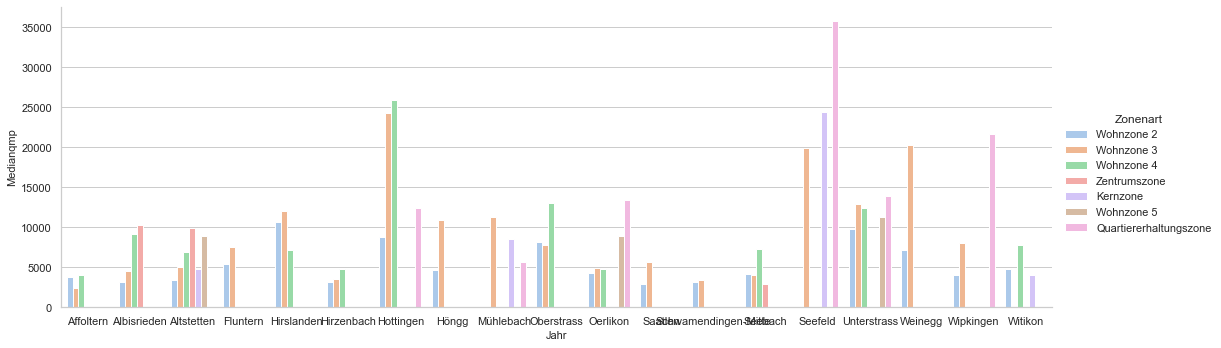

In [31]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(data=data2betested.loc["2018"].reset_index().query('Quartier_Nummer > 60')
                     , x="Quartier_Name"
            , y="Medianqmp"
            , hue="Zonenart"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Medianqmp', fontsize=11)


In [32]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Zonenart           object
Anzahl_HAE         object
dtype: object

##### Entwicklung aller Freihandkäufe nach Hauptgrundstücktyp seit 2009

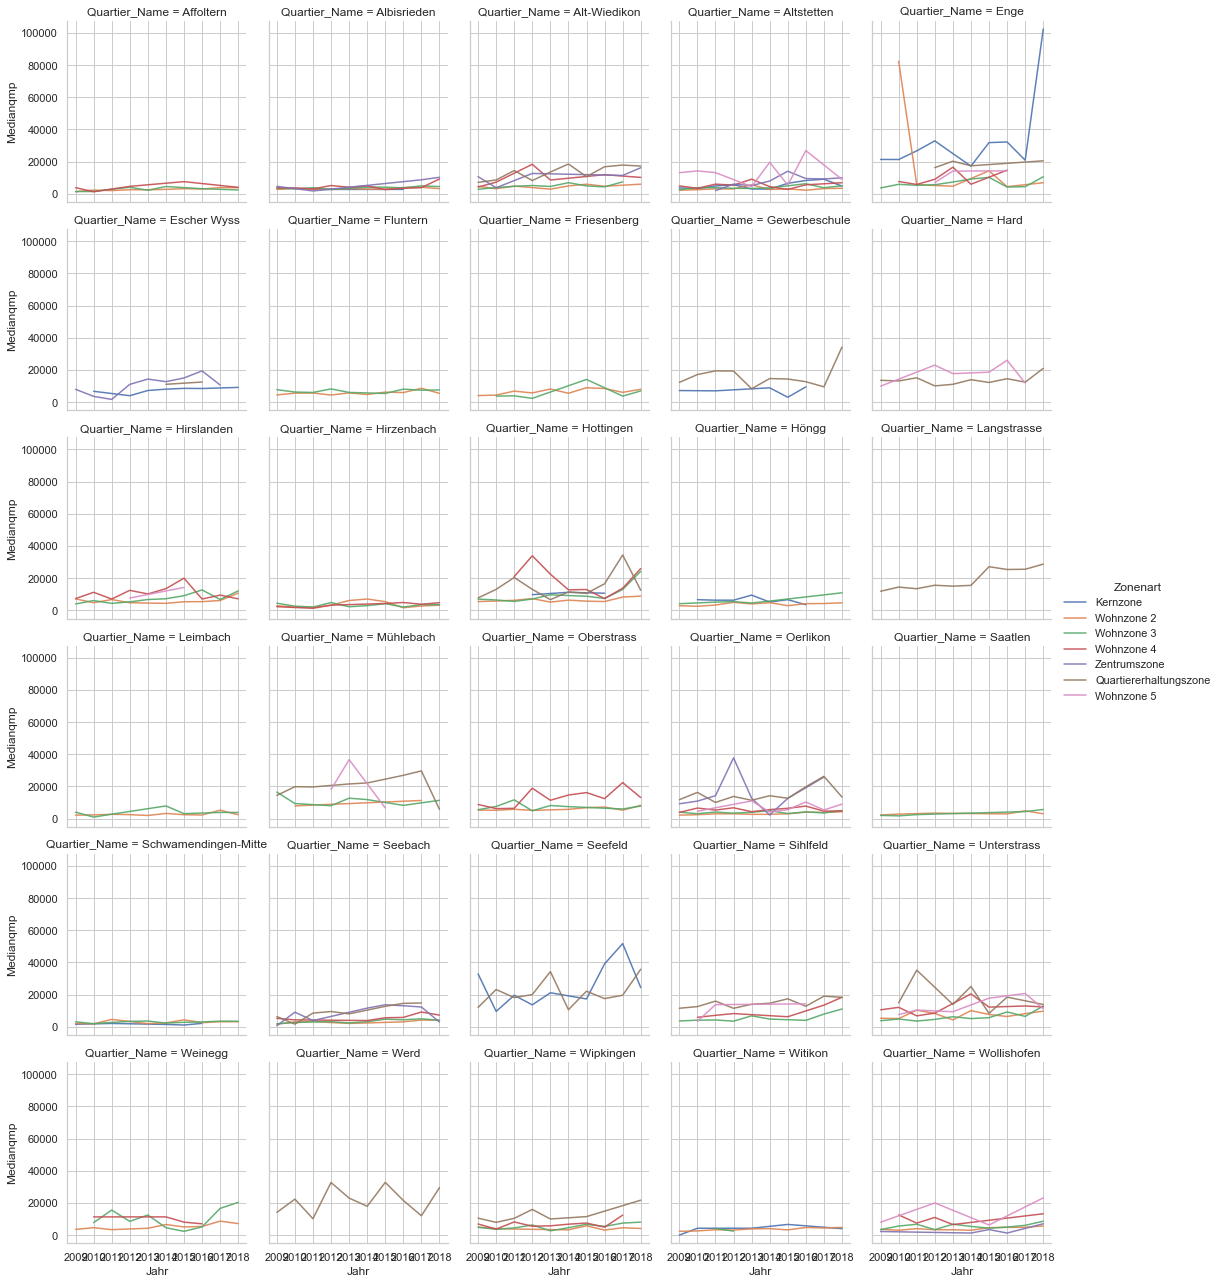

In [33]:
g = sns.FacetGrid(data=data2betested.loc["2009":"2018"].query('Quartier_Nummer > 20').reset_index(), col="Quartier_Name", hue="Zonenart", col_wrap=5, height=3)
#g.map(sns.scatterplot, "Jahr", "Medianqmp", alpha=.8)
g.map(sns.lineplot, "Jahr","Medianqmp", alpha=.9)
g.add_legend()




### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Medianquadratmeterpreis nach Zone und Quartier im 2017-2018

In [34]:
myTreemap = data2betested.loc["2017":"2018"]\
    .groupby(['Jahr', 'Quartier_Name', 'Quartier_Nummer', 'Zonenart' ]) \
    .agg(sum_Anzahl_HAE=('Anzahl_HAE', 'sum')) \
    .sort_values('Jahr', ascending=False) 
myTreemap.reset_index().head(2)

,Jahr,Quartier_Name,Quartier_Nummer,Zonenart,sum_Anzahl_HAE
0,2018-01-01,Albisrieden,91,Zentrumszone,1–3
1,2018-01-01,Hottingen,72,Wohnzone 3,1–3


In [35]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Zonenart           object
Anzahl_HAE         object
dtype: object

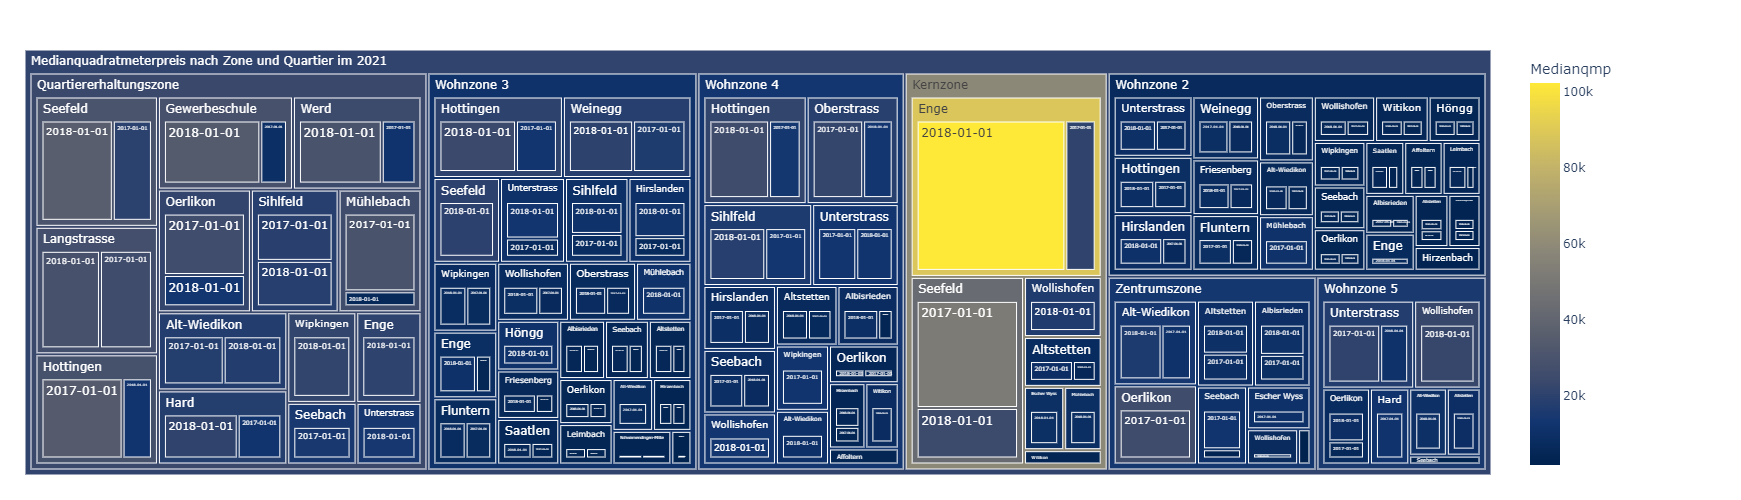

In [38]:
fig = px.treemap(data2betested.loc["2017":"2021"].query('Quartier_Nummer > 20').reset_index()
                 , path=[px.Constant("Medianquadratmeterpreis nach Zone und Quartier im 2021")
                         ,'Zonenart','Quartier_Name','Jahr']
                 , values='Medianqmp'
                 , color='Medianqmp'               
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                 ,color_continuous_scale='cividis'
                 ,height=500 , width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [37]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=572&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [44]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [45]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [46]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [47]:
m = leafmap.Map()


#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [38]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Zonenart           object
Anzahl_HAE         object
dtype: object

In [ ]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


In [40]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [ ]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)

In [ ]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

In [ ]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=572&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**